<a href="https://colab.research.google.com/github/simasaadi/canada-climate-80yrs/blob/main/03_exploratory_analysis_trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notebook 03 — Exploratory Analysis & Trend Diagnostics (1940–Present)

This notebook loads the processed climate datasets (daily tidy + monthly + yearly) and performs senior-level EDA:
- coverage and missingness checks by city
- trend estimation (per decade) with confidence intervals
- seasonality diagnostics and rolling variability
- cross-city anomaly correlation
- export of publication-ready figures and summary tables to `reports/eda/`



In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path
from dataclasses import dataclass
from typing import Iterable, Optional, Tuple, Dict

# Display & reproducibility
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

# Output folders
REPORT_DIR = Path("/content/canada-climate-80yrs/reports/eda")
FIG_DIR = REPORT_DIR / "figures"
TABLE_DIR = REPORT_DIR / "tables"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)

print("Report dir:", REPORT_DIR)


In [9]:
from pathlib import Path

REPO_DIR = Path("/content/canada-climate-80yrs")
RAW_PATH = REPO_DIR / "data" / "raw" / "canadian_climate_daily.csv"

print("Raw exists:", RAW_PATH.exists(), "|", RAW_PATH)
if RAW_PATH.exists():
    print("Raw size (MB):", round(RAW_PATH.stat().st_size / 1e6, 2))
    !ls -lah /content/canada-climate-80yrs/data/raw


Raw exists: True | /content/canada-climate-80yrs/data/raw/canadian_climate_daily.csv
Raw size (MB): 3.87
total 3.7M
drwxr-xr-x 2 root root 4.0K Dec 12 19:45 .
drwxr-xr-x 3 root root 4.0K Dec 12 19:45 ..
-rw-r--r-- 1 root root 3.7M Dec 12 19:45 canadian_climate_daily.csv
-rw-r--r-- 1 root root    1 Dec 12 19:45 .gitkeep


In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

REPO_DIR = Path("/content/canada-climate-80yrs")
RAW_PATH = REPO_DIR / "data" / "raw" / "canadian_climate_daily.csv"
PROCESSED_DIR = REPO_DIR / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

TIDY_PATH    = PROCESSED_DIR / "climate_daily_tidy.parquet"
MONTHLY_PATH = PROCESSED_DIR / "climate_monthly.parquet"
YEARLY_PATH  = PROCESSED_DIR / "climate_yearly.parquet"

def build_processed(raw_path: Path):
    df = pd.read_csv(raw_path)
    df["LOCAL_DATE"] = pd.to_datetime(df["LOCAL_DATE"], errors="coerce")
    assert df["LOCAL_DATE"].isna().sum() == 0, "LOCAL_DATE parsing failed"

    # identify series columns like MEAN_TEMPERATURE_CITY and TOTAL_PRECIPITATION_CITY
    pat = re.compile(r"^(MEAN_TEMPERATURE|TOTAL_PRECIPITATION)_(.+)$")
    long_parts = []
    for col in df.columns:
        if col == "LOCAL_DATE":
            continue
        m = pat.match(col)
        if not m:
            continue
        var, city = m.group(1), m.group(2)
        tmp = df[["LOCAL_DATE", col]].rename(columns={col: "value"})
        tmp["variable"] = var.lower()
        tmp["city"] = city
        long_parts.append(tmp)

    df_long = pd.concat(long_parts, ignore_index=True)
    df_tidy = (
        df_long.pivot_table(index=["LOCAL_DATE", "city"], columns="variable", values="value", aggfunc="first")
              .reset_index()
              .rename(columns={"LOCAL_DATE": "local_date",
                               "mean_temperature": "mean_temperature",
                               "total_precipitation": "total_precipitation"})
    )

    df_tidy["year"] = df_tidy["local_date"].dt.year
    df_tidy["month"] = df_tidy["local_date"].dt.month
    df_tidy["dayofyear"] = df_tidy["local_date"].dt.dayofyear
    df_tidy["is_freezing"] = df_tidy["mean_temperature"] <= 0
    df_tidy["precip_positive"] = df_tidy["total_precipitation"] > 0

    # monthly + yearly summaries (clean, consistent)
    monthly = (
        df_tidy.groupby(["city", "year", "month"], as_index=False)
               .agg(mean_temp=("mean_temperature", "mean"),
                    total_precip=("total_precipitation", "sum"),
                    n_obs_temp=("mean_temperature", "count"),
                    n_obs_precip=("total_precipitation", "count"))
    )
    yearly = (
        df_tidy.groupby(["city", "year"], as_index=False)
               .agg(mean_temp=("mean_temperature", "mean"),
                    total_precip=("total_precipitation", "sum"),
                    n_obs_temp=("mean_temperature", "count"),
                    n_obs_precip=("total_precipitation", "count"))
    )

    df_tidy.to_parquet(TIDY_PATH, index=False)
    monthly.to_parquet(MONTHLY_PATH, index=False)
    yearly.to_parquet(YEARLY_PATH, index=False)

# Build only if missing
if not (TIDY_PATH.exists() and MONTHLY_PATH.exists() and YEARLY_PATH.exists()):
    print("Processed outputs missing -> building now...")
    build_processed(RAW_PATH)

print("Processed dir exists:", PROCESSED_DIR.exists())
print("Daily tidy exists:", TIDY_PATH.exists())
print("Monthly exists:", MONTHLY_PATH.exists())
print("Yearly exists:", YEARLY_PATH.exists())
!ls -lah /content/canada-climate-80yrs/data/processed


Processed outputs missing -> building now...
Processed dir exists: True
Daily tidy exists: True
Monthly exists: True
Yearly exists: True
total 1.4M
drwxr-xr-x 2 root root 4.0K Dec 12 19:47 .
drwxr-xr-x 4 root root 4.0K Dec 12 19:47 ..
-rw-r--r-- 1 root root 1.3M Dec 12 19:47 climate_daily_tidy.parquet
-rw-r--r-- 1 root root 108K Dec 12 19:47 climate_monthly.parquet
-rw-r--r-- 1 root root  21K Dec 12 19:47 climate_yearly.parquet


In [11]:
df_daily   = pd.read_parquet(TIDY_PATH)
df_monthly = pd.read_parquet(MONTHLY_PATH)
df_yearly  = pd.read_parquet(YEARLY_PATH)

print(df_daily.shape, df_monthly.shape, df_yearly.shape)
df_daily.head(3)


(355513, 9) (11731, 7) (998, 6)


,local_date,city,mean_temperature,total_precipitation,year,month,dayofyear,is_freezing,precip_positive
0,1940-01-01,CALGARY,-11.4,0.5,1940,1,1,True,True
1,1940-01-01,MONCTON,-8.9,0.0,1940,1,1,True,False
2,1940-01-01,OTTAWA,-17.0,0.0,1940,1,1,True,False


In [12]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path
from dataclasses import dataclass
from typing import Iterable, Optional, Tuple, Dict

# Display & reproducibility
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

# Output folders
REPORT_DIR = Path("/content/canada-climate-80yrs/reports/eda")
FIG_DIR = REPORT_DIR / "figures"
TABLE_DIR = REPORT_DIR / "tables"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)

print("Report dir:", REPORT_DIR)


Report dir: /content/canada-climate-80yrs/reports/eda


In [13]:
def assert_expected_schema(df_daily: pd.DataFrame, df_monthly: pd.DataFrame, df_yearly: pd.DataFrame) -> None:
    daily_cols = {"local_date","city","mean_temperature","total_precipitation","year","month","dayofyear","is_freezing","precip_positive"}
    monthly_cols = {"city","year","month","mean_temp","total_precip","n_obs_temp","n_obs_precip"}
    yearly_cols = {"city","year","mean_temp","total_precip","n_obs_temp","n_obs_precip"}

    missing_daily = daily_cols - set(df_daily.columns)
    missing_monthly = monthly_cols - set(df_monthly.columns)
    missing_yearly = yearly_cols - set(df_yearly.columns)

    assert not missing_daily, f"Missing daily cols: {missing_daily}"
    assert not missing_monthly, f"Missing monthly cols: {missing_monthly}"
    assert not missing_yearly, f"Missing yearly cols: {missing_yearly}"

assert_expected_schema(df_daily, df_monthly, df_yearly)

print("Cities:", df_daily["city"].nunique())
print("Daily date range:", df_daily["local_date"].min(), "->", df_daily["local_date"].max())

# Basic missingness overview (daily)
daily_missing = df_daily[["mean_temperature","total_precipitation"]].isna().mean().mul(100).round(2)
print("Daily missing %:\n", daily_missing)

# Coverage per city (days with both metrics)
cov = (
    df_daily.assign(has_both = df_daily["mean_temperature"].notna() & df_daily["total_precipitation"].notna())
    .groupby("city", as_index=False)
    .agg(
        start=("local_date","min"),
        end=("local_date","max"),
        n_days=("local_date","count"),
        pct_has_both=("has_both","mean"),
        pct_temp=("mean_temperature", lambda s: s.notna().mean()),
        pct_precip=("total_precipitation", lambda s: s.notna().mean())
    )
)
cov["pct_has_both"] = (cov["pct_has_both"]*100).round(2)
cov["pct_temp"] = (cov["pct_temp"]*100).round(2)
cov["pct_precip"] = (cov["pct_precip"]*100).round(2)

cov.sort_values(["pct_has_both","n_days"], ascending=[False, False]).head(15)


Cities: 13
Daily date range: 1940-01-01 00:00:00 -> 2020-01-01 00:00:00
Daily missing %:
 mean_temperature       0.07
total_precipitation    1.28
dtype: float64


,city,start,end,n_days,pct_has_both,pct_temp,pct_precip
5,OTTAWA,1940-01-01,2020-01-01,29150,99.95,99.98,99.97
10,VANCOUVER,1940-01-01,2020-01-01,29179,99.92,99.96,99.96
9,TORONTO,1940-01-01,2020-01-01,29155,99.92,99.97,99.95
6,QUEBEC,1943-03-26,2020-01-01,28020,99.86,99.95,99.91
0,CALGARY,1940-01-01,2020-01-01,29064,99.83,99.89,99.94
8,STJOHNS,1942-01-01,2020-01-01,28436,99.79,99.92,99.87
1,EDMONTON,1959-05-08,2020-01-01,21594,99.77,99.86,99.91
4,MONTREAL,1941-09-01,2020-01-01,28514,99.75,99.83,99.92
12,WINNIPEG,1940-01-01,2020-01-01,29104,99.53,99.98,99.55
2,HALIFAX,1953-01-22,2020-01-01,22082,99.49,99.89,99.61


In [14]:
cov.sort_values("city").to_csv(TABLE_DIR / "city_coverage_summary.csv", index=False)
print("Saved:", TABLE_DIR / "city_coverage_summary.csv")


Saved: /content/canada-climate-80yrs/reports/eda/tables/city_coverage_summary.csv


In [15]:
def pick_top_cities(cov: pd.DataFrame, min_pct_has_both: float = 85.0, top_n: int = 8) -> list:
    tmp = cov[cov["pct_has_both"] >= min_pct_has_both].copy()
    if tmp.empty:
        tmp = cov.sort_values("pct_has_both", ascending=False).head(top_n)
    else:
        tmp = tmp.sort_values(["pct_has_both","n_days"], ascending=[False, False]).head(top_n)
    return tmp["city"].tolist()

TOP_CITIES = pick_top_cities(cov, min_pct_has_both=85.0, top_n=8)
TOP_CITIES


['OTTAWA',
 'VANCOUVER',
 'TORONTO',
 'QUEBEC',
 'CALGARY',
 'STJOHNS',
 'EDMONTON',
 'MONTREAL']

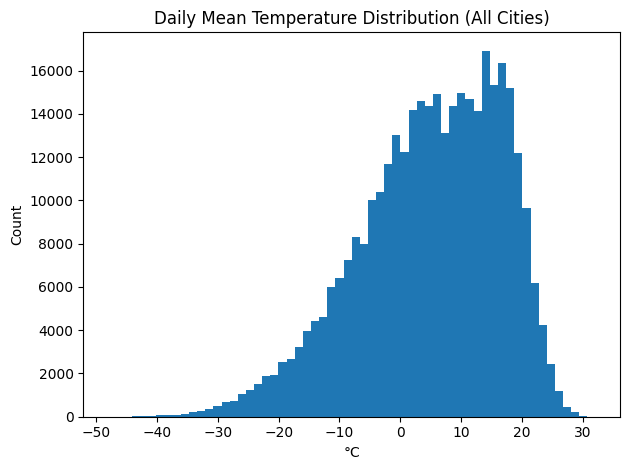

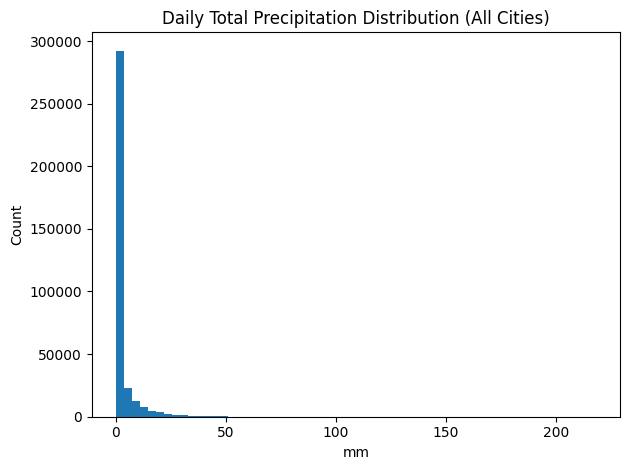

{'temp_below_-60': 0, 'temp_above_50': 0, 'precip_negative': 0}


,city,pct_zero
8,STJOHNS,41.75
6,QUEBEC,51.59
3,MONCTON,53.25
4,MONTREAL,53.80
2,HALIFAX,53.95
10,VANCOUVER,54.95
5,OTTAWA,56.73
9,TORONTO,61.29
11,WHITEHORSE,61.32
12,WINNIPEG,64.51


In [16]:
def plot_hist(series: pd.Series, title: str, xlabel: str, fname: str, bins: int = 60):
    s = series.dropna()
    plt.figure()
    plt.hist(s, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.tight_layout()
    out = FIG_DIR / fname
    plt.savefig(out, dpi=160)
    plt.show()
    return out

_ = plot_hist(df_daily["mean_temperature"], "Daily Mean Temperature Distribution (All Cities)", "°C", "hist_temp_all.png")
_ = plot_hist(df_daily["total_precipitation"], "Daily Total Precipitation Distribution (All Cities)", "mm", "hist_precip_all.png")

# Simple outlier scan (conservative)
temp_low = (df_daily["mean_temperature"] < -60).sum()
temp_high = (df_daily["mean_temperature"] > 50).sum()
precip_neg = (df_daily["total_precipitation"] < 0).sum()

print({"temp_below_-60": int(temp_low), "temp_above_50": int(temp_high), "precip_negative": int(precip_neg)})

# Precip zero share by city (interpretable feature)
precip_zero = (
    df_daily.assign(is_zero = df_daily["total_precipitation"].fillna(np.nan).eq(0))
    .groupby("city", as_index=False)
    .agg(pct_zero=("is_zero","mean"))
)
precip_zero["pct_zero"] = (precip_zero["pct_zero"]*100).round(2)
precip_zero.sort_values("pct_zero").head(10)


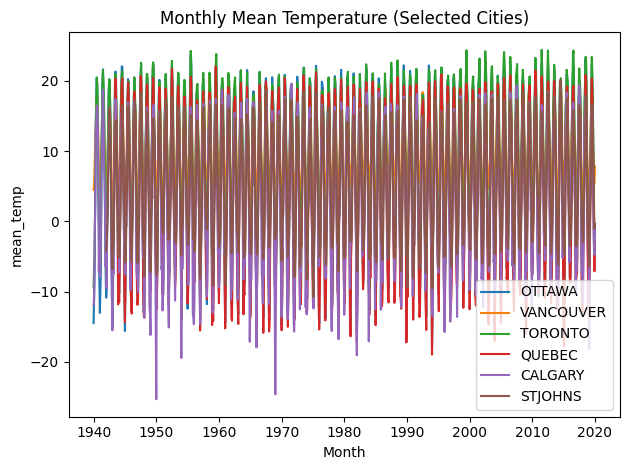

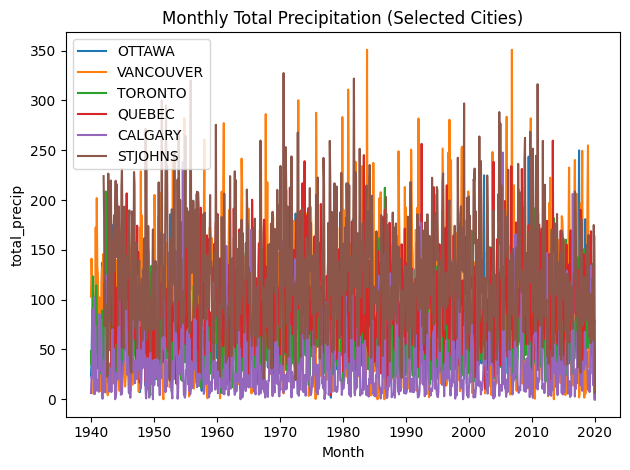

In [17]:
def plot_monthly_series(df_monthly: pd.DataFrame, cities: Iterable[str], metric: str, title: str, fname: str):
    # metric in {"mean_temp","total_precip"}
    tmp = df_monthly[df_monthly["city"].isin(list(cities))].copy()
    tmp["month_start"] = pd.to_datetime(tmp[["year","month"]].assign(day=1))

    plt.figure()
    for c in cities:
        s = tmp[tmp["city"] == c].sort_values("month_start")
        plt.plot(s["month_start"], s[metric], label=c)
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel(metric)
    plt.legend()
    plt.tight_layout()
    out = FIG_DIR / fname
    plt.savefig(out, dpi=160)
    plt.show()
    return out

_ = plot_monthly_series(df_monthly, TOP_CITIES[:6], "mean_temp",
                        "Monthly Mean Temperature (Selected Cities)", "monthly_temp_selected.png")

_ = plot_monthly_series(df_monthly, TOP_CITIES[:6], "total_precip",
                        "Monthly Total Precipitation (Selected Cities)", "monthly_precip_selected.png")


In [18]:
@dataclass
class TrendResult:
    city: str
    metric: str
    start_year: int
    end_year: int
    n_years: int
    slope_per_year: float
    slope_per_decade: float
    intercept: float
    r2: float
    se_slope: float
    ci95_low_decade: float
    ci95_high_decade: float

def linear_trend(y: np.ndarray, x: np.ndarray) -> Tuple[float,float,float,float,float]:
    # returns slope, intercept, r2, se_slope, n
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]; y = y[mask]
    n = len(x)
    if n < 3:
        return np.nan, np.nan, np.nan, np.nan, n

    x0 = x - x.mean()
    slope = np.sum(x0*(y - y.mean())) / np.sum(x0**2)
    intercept = y.mean() - slope*x.mean()

    yhat = intercept + slope*x
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    # standard error of slope
    dof = n - 2
    mse = ss_res / dof if dof > 0 else np.nan
    se_slope = np.sqrt(mse / np.sum(x0**2)) if np.sum(x0**2) > 0 else np.nan

    return slope, intercept, r2, se_slope, n

def compute_city_trends(df_yearly: pd.DataFrame,
                        metric: str,
                        min_years: int = 40,
                        min_obs_per_year: int = 300) -> pd.DataFrame:
    # metric in {"mean_temp","total_precip"}
    obs_col = "n_obs_temp" if metric == "mean_temp" else "n_obs_precip"

    tmp = df_yearly.copy()
    tmp = tmp[tmp[obs_col] >= min_obs_per_year].copy()

    rows = []
    for city, g in tmp.groupby("city"):
        g = g.sort_values("year")
        x = g["year"].to_numpy(dtype=float)
        y = g[metric].to_numpy(dtype=float)

        slope, intercept, r2, se_slope, n = linear_trend(y, x)
        if n < min_years or not np.isfinite(slope):
            continue

        # 95% CI using normal approx (fine for large n)
        ci_low = (slope - 1.96*se_slope) * 10
        ci_high = (slope + 1.96*se_slope) * 10

        rows.append(TrendResult(
            city=city,
            metric=metric,
            start_year=int(g["year"].min()),
            end_year=int(g["year"].max()),
            n_years=int(n),
            slope_per_year=float(slope),
            slope_per_decade=float(slope*10),
            intercept=float(intercept),
            r2=float(r2),
            se_slope=float(se_slope),
            ci95_low_decade=float(ci_low),
            ci95_high_decade=float(ci_high),
        ).__dict__)

    out = pd.DataFrame(rows)
    if not out.empty:
        out = out.sort_values("slope_per_decade", ascending=False)
    return out

temp_trends = compute_city_trends(df_yearly, metric="mean_temp", min_years=40, min_obs_per_year=300)
precip_trends = compute_city_trends(df_yearly, metric="total_precip", min_years=40, min_obs_per_year=300)

temp_trends.head(10)


,city,metric,start_year,end_year,n_years,slope_per_year,slope_per_decade,intercept,r2,se_slope,ci95_low_decade,ci95_high_decade
12,WINNIPEG,mean_temp,1940,2019,80,0.027837,0.278374,-52.119126,0.241363,0.005588,0.168847,0.387900
9,TORONTO,mean_temp,1940,2019,80,0.022291,0.222906,-36.247806,0.258853,0.004271,0.139200,0.306611
0,CALGARY,mean_temp,1940,2019,80,0.021827,0.218268,-39.160727,0.200173,0.004940,0.121441,0.315095
2,HALIFAX,mean_temp,1953,2019,60,0.021488,0.214883,-36.180944,0.227702,0.005196,0.113035,0.316731
11,WHITEHORSE,mean_temp,1943,2019,74,0.021458,0.214584,-42.940750,0.159635,0.005802,0.100859,0.328310
1,EDMONTON,mean_temp,1961,2019,59,0.015875,0.158745,-29.280042,0.059195,0.008382,-0.005551,0.323042
5,OTTAWA,mean_temp,1940,2019,80,0.014261,0.142611,-22.100259,0.167723,0.003597,0.072109,0.213112
4,MONTREAL,mean_temp,1942,2019,78,0.013962,0.139617,-20.967569,0.131881,0.004109,0.059082,0.220152
7,SASKATOON,mean_temp,1940,2019,73,0.013329,0.133295,-24.266718,0.063190,0.006091,0.013912,0.252678
10,VANCOUVER,mean_temp,1940,2019,80,0.012608,0.126076,-14.806402,0.201956,0.002838,0.070456,0.181695


In [19]:
temp_trends.to_csv(TABLE_DIR / "trend_temperature_by_city.csv", index=False)
precip_trends.to_csv(TABLE_DIR / "trend_precip_by_city.csv", index=False)
print("Saved:",
      TABLE_DIR / "trend_temperature_by_city.csv",
      TABLE_DIR / "trend_precip_by_city.csv")


Saved: /content/canada-climate-80yrs/reports/eda/tables/trend_temperature_by_city.csv /content/canada-climate-80yrs/reports/eda/tables/trend_precip_by_city.csv


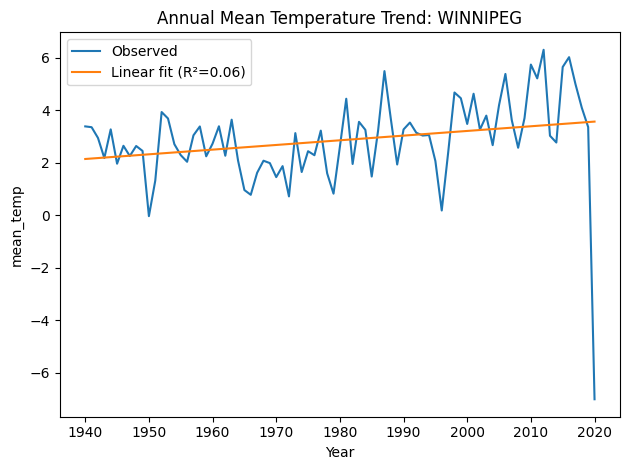

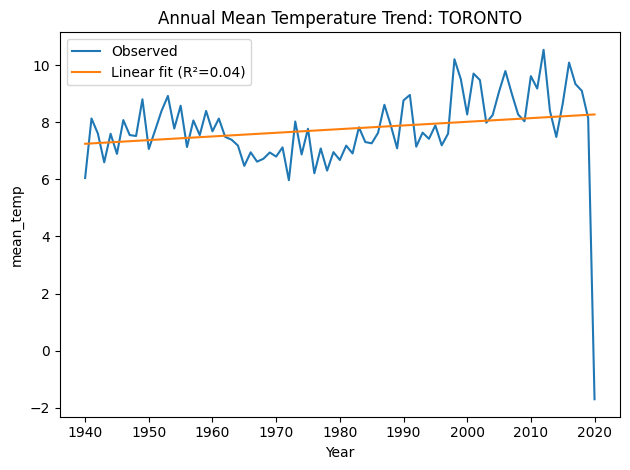

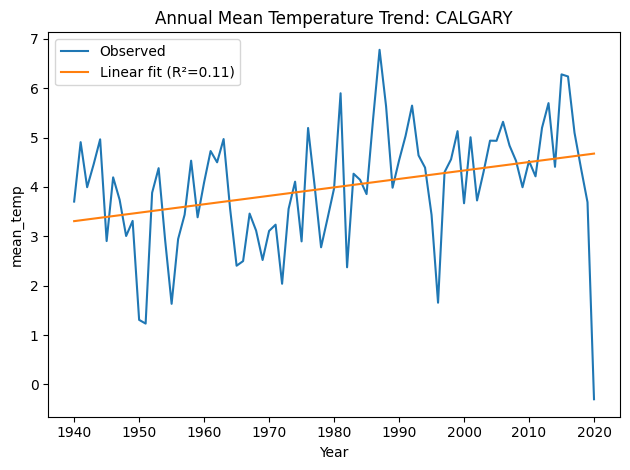

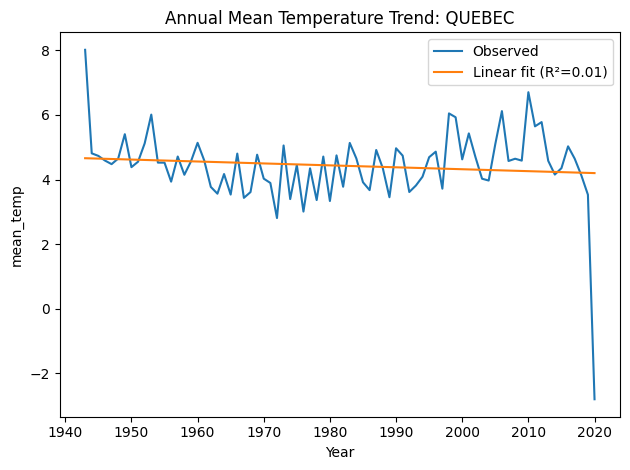

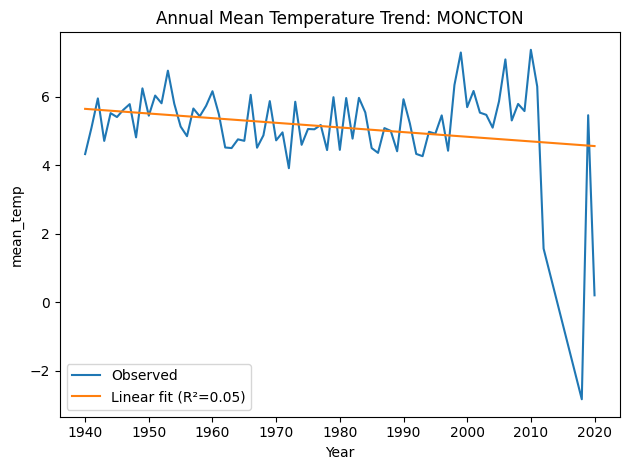

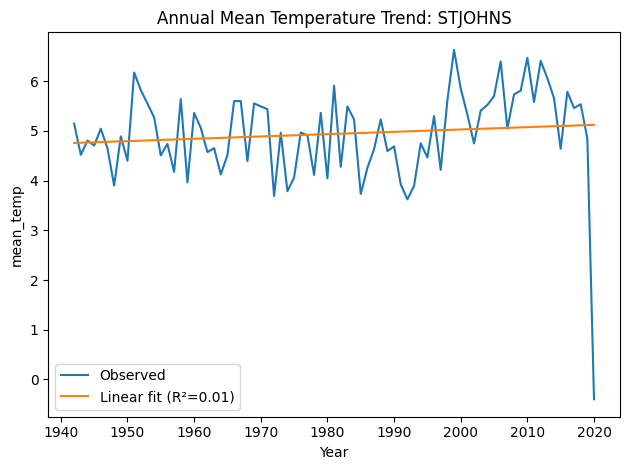

In [20]:
def plot_city_annual_with_fit(df_yearly: pd.DataFrame, city: str, metric: str, title: str, fname: str):
    g = df_yearly[df_yearly["city"] == city].sort_values("year").copy()
    x = g["year"].to_numpy(dtype=float)
    y = g[metric].to_numpy(dtype=float)

    slope, intercept, r2, se_slope, n = linear_trend(y, x)
    yhat = intercept + slope*x

    plt.figure()
    plt.plot(g["year"], y, label="Observed")
    plt.plot(g["year"], yhat, label=f"Linear fit (R²={r2:.2f})")
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(metric)
    plt.legend()
    plt.tight_layout()
    out = FIG_DIR / fname
    plt.savefig(out, dpi=160)
    plt.show()
    return out

# pick 3 warmest-trend and 3 coolest-trend (if available)
if len(temp_trends) >= 6:
    top_warm = temp_trends.sort_values("slope_per_decade", ascending=False).head(3)["city"].tolist()
    top_cool = temp_trends.sort_values("slope_per_decade", ascending=True).head(3)["city"].tolist()
else:
    top_warm, top_cool = TOP_CITIES[:3], TOP_CITIES[-3:]

for c in top_warm:
    _ = plot_city_annual_with_fit(df_yearly, c, "mean_temp",
                                  f"Annual Mean Temperature Trend: {c}",
                                  f"annual_temp_trend_{c}.png")

for c in top_cool:
    _ = plot_city_annual_with_fit(df_yearly, c, "mean_temp",
                                  f"Annual Mean Temperature Trend: {c}",
                                  f"annual_temp_trend_{c}.png")


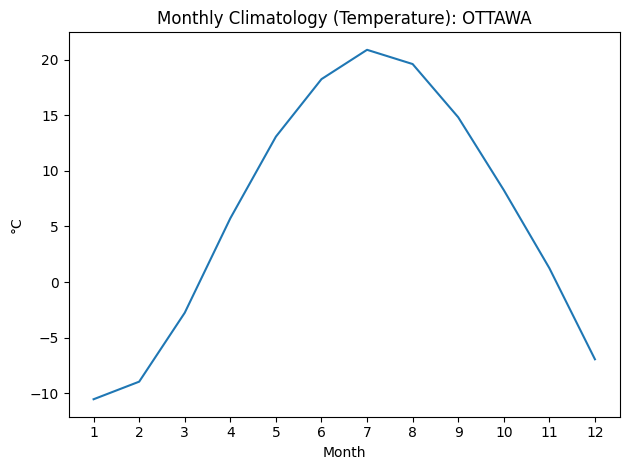

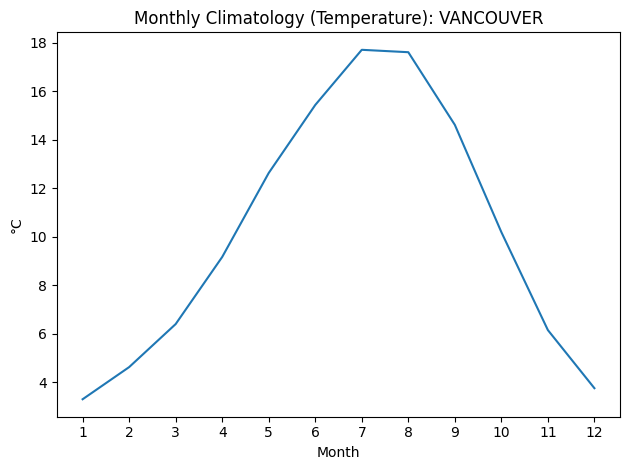

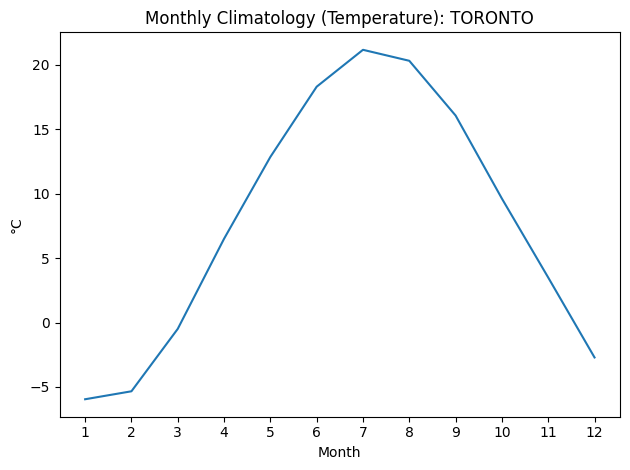

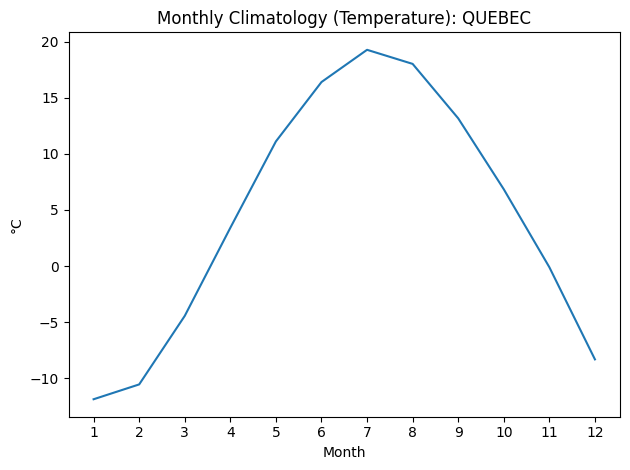

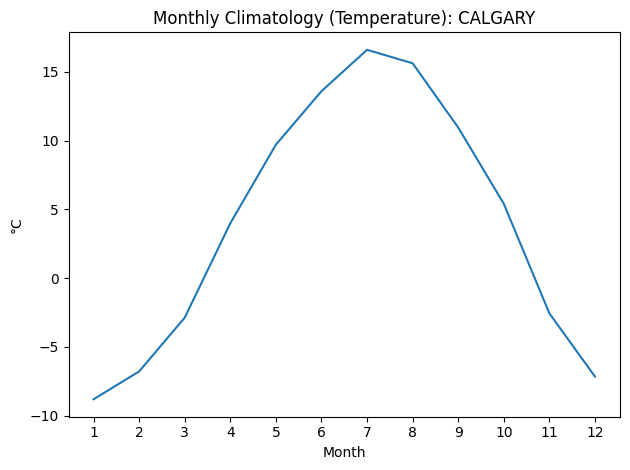

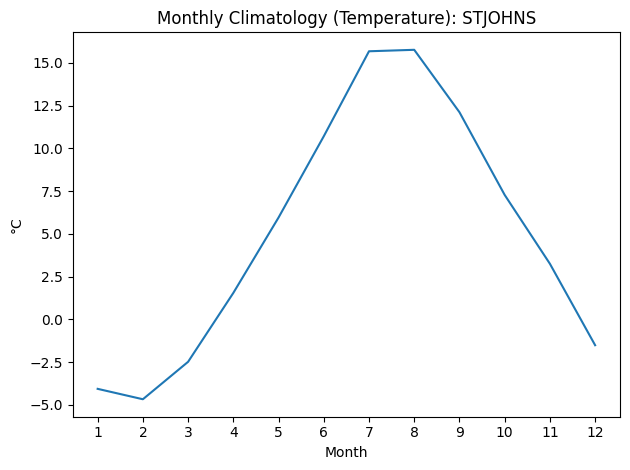

In [21]:
def monthly_climatology(df_monthly: pd.DataFrame, city: str) -> pd.DataFrame:
    g = df_monthly[df_monthly["city"] == city].copy()
    out = (
        g.groupby("month", as_index=False)
         .agg(temp_clim=("mean_temp","mean"),
              precip_clim=("total_precip","mean"),
              n=("mean_temp","count"))
         .sort_values("month")
    )
    return out

def plot_climatology(df_monthly: pd.DataFrame, city: str, fname: str):
    clim = monthly_climatology(df_monthly, city)
    plt.figure()
    plt.plot(clim["month"], clim["temp_clim"], label="Mean Temp (°C)")
    plt.title(f"Monthly Climatology (Temperature): {city}")
    plt.xlabel("Month")
    plt.ylabel("°C")
    plt.xticks(range(1,13))
    plt.tight_layout()
    out = FIG_DIR / fname
    plt.savefig(out, dpi=160)
    plt.show()
    return out

for c in TOP_CITIES[:6]:
    _ = plot_climatology(df_monthly, c, f"climatology_temp_{c}.png")


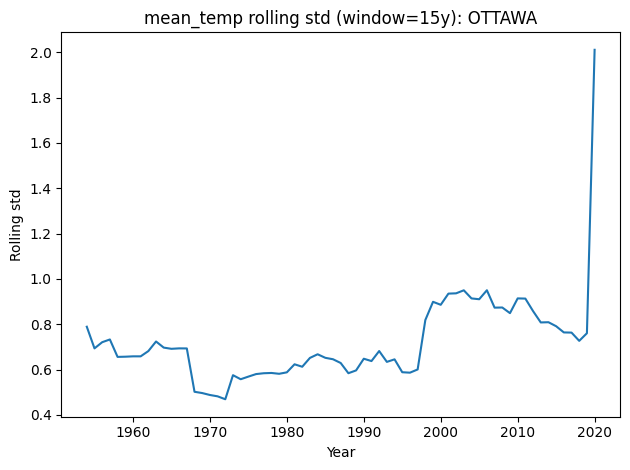

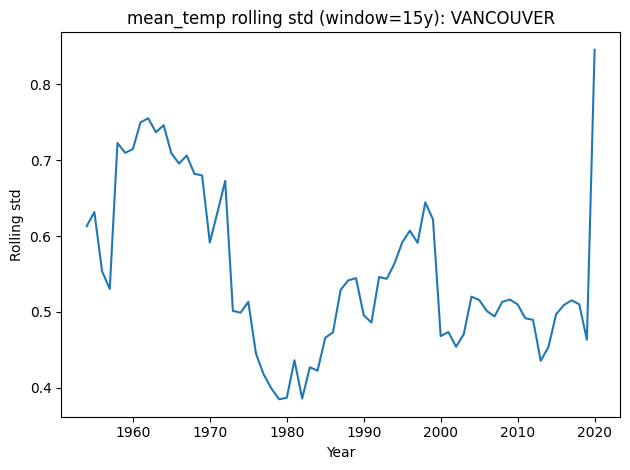

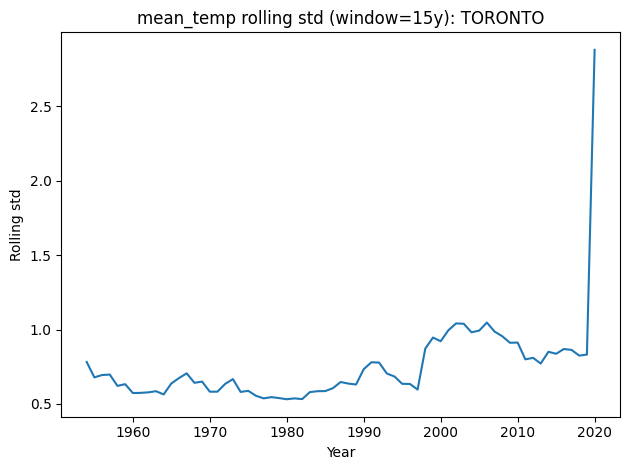

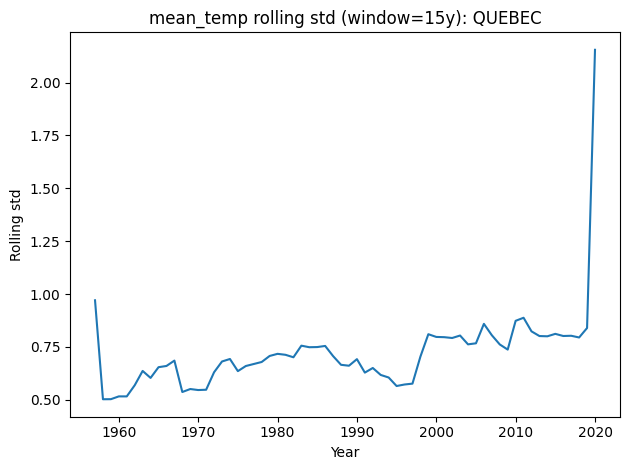

In [22]:
def rolling_std_annual(df_yearly: pd.DataFrame, city: str, metric: str, window: int = 15) -> pd.DataFrame:
    g = df_yearly[df_yearly["city"] == city].sort_values("year").copy()
    g["roll_std"] = g[metric].rolling(window=window, min_periods=window).std()
    return g[["year", "roll_std"]]

def plot_rolling_std(df_yearly: pd.DataFrame, city: str, metric: str, window: int, fname: str):
    g = rolling_std_annual(df_yearly, city, metric, window=window)
    plt.figure()
    plt.plot(g["year"], g["roll_std"])
    plt.title(f"{metric} rolling std (window={window}y): {city}")
    plt.xlabel("Year")
    plt.ylabel("Rolling std")
    plt.tight_layout()
    out = FIG_DIR / fname
    plt.savefig(out, dpi=160)
    plt.show()
    return out

for c in TOP_CITIES[:4]:
    _ = plot_rolling_std(df_yearly, c, "mean_temp", window=15, fname=f"rolling_std_temp_{c}.png")


In [23]:
def monthly_anomalies(df_monthly: pd.DataFrame, metric: str) -> pd.DataFrame:
    # metric in {"mean_temp","total_precip"}
    base = df_monthly.copy()
    clim = base.groupby(["city","month"], as_index=False)[metric].mean().rename(columns={metric:"clim"})
    out = base.merge(clim, on=["city","month"], how="left")
    out["anom"] = out[metric] - out["clim"]
    out["month_start"] = pd.to_datetime(out[["year","month"]].assign(day=1))
    return out[["city","month_start","anom"]]

anom_temp = monthly_anomalies(df_monthly, "mean_temp")

# Wide matrix for correlations (cities as columns)
wide = anom_temp.pivot_table(index="month_start", columns="city", values="anom", aggfunc="mean")
corr = wide[TOP_CITIES].corr(min_periods=120)  # require 10 years of overlap

corr.to_csv(TABLE_DIR / "corr_monthly_temp_anomalies_top_cities.csv")
print("Saved:", TABLE_DIR / "corr_monthly_temp_anomalies_top_cities.csv")
corr


Saved: /content/canada-climate-80yrs/reports/eda/tables/corr_monthly_temp_anomalies_top_cities.csv


city,OTTAWA,VANCOUVER,TORONTO,QUEBEC,CALGARY,STJOHNS,EDMONTON,MONTREAL
city,,,,,,,,
OTTAWA,1.000000,-0.021327,0.894420,0.907261,0.153369,0.216975,0.187705,0.970328
VANCOUVER,-0.021327,1.000000,0.002547,0.014449,0.631489,0.251984,0.554360,-0.001491
TORONTO,0.894420,0.002547,1.000000,0.758579,0.185246,0.146186,0.212793,0.882804
QUEBEC,0.907261,0.014449,0.758579,1.000000,0.101021,0.397423,0.146169,0.918980
CALGARY,0.153369,0.631489,0.185246,0.101021,1.000000,0.199130,0.937197,0.141984
STJOHNS,0.216975,0.251984,0.146186,0.397423,0.199130,1.000000,0.143771,0.275210
EDMONTON,0.187705,0.554360,0.212793,0.146169,0.937197,0.143771,1.000000,0.179428
MONTREAL,0.970328,-0.001491,0.882804,0.918980,0.141984,0.275210,0.179428,1.000000


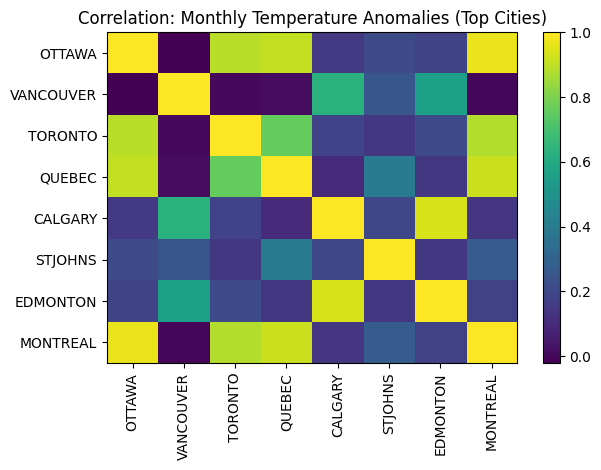

In [24]:
plt.figure()
plt.imshow(corr.to_numpy(), aspect="auto")
plt.title("Correlation: Monthly Temperature Anomalies (Top Cities)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.tight_layout()
plt.savefig(FIG_DIR / "corr_temp_anomalies_top_cities.png", dpi=160)
plt.show()


In [25]:
def summarize_trends(temp_trends: pd.DataFrame, precip_trends: pd.DataFrame, top_k: int = 10) -> pd.DataFrame:
    t = temp_trends.copy()
    p = precip_trends.copy()

    t = t.rename(columns={
        "slope_per_decade":"temp_trend_per_decade",
        "ci95_low_decade":"temp_ci95_low",
        "ci95_high_decade":"temp_ci95_high",
        "r2":"temp_r2"
    })[["city","temp_trend_per_decade","temp_ci95_low","temp_ci95_high","temp_r2","n_years"]]

    p = p.rename(columns={
        "slope_per_decade":"precip_trend_per_decade",
        "ci95_low_decade":"precip_ci95_low",
        "ci95_high_decade":"precip_ci95_high",
        "r2":"precip_r2"
    })[["city","precip_trend_per_decade","precip_ci95_low","precip_ci95_high","precip_r2","n_years"]]

    out = t.merge(p, on="city", how="outer", suffixes=("_temp","_precip"))
    out = out.sort_values("temp_trend_per_decade", ascending=False)
    return out.head(top_k)

summary_top = summarize_trends(temp_trends, precip_trends, top_k=12)
summary_top.to_csv(TABLE_DIR / "executive_summary_top_trends.csv", index=False)
print("Saved:", TABLE_DIR / "executive_summary_top_trends.csv")
summary_top


Saved: /content/canada-climate-80yrs/reports/eda/tables/executive_summary_top_trends.csv


,city,temp_trend_per_decade,temp_ci95_low,temp_ci95_high,temp_r2,n_years_temp,precip_trend_per_decade,precip_ci95_low,precip_ci95_high,precip_r2,n_years_precip
12,WINNIPEG,0.278374,0.168847,0.387900,0.241363,80,-1.883984,-11.512392,7.744425,0.001882,80
9,TORONTO,0.222906,0.139200,0.306611,0.258853,80,4.702121,-6.158167,15.562410,0.009148,80
0,CALGARY,0.218268,0.121441,0.315095,0.200173,80,-1.295476,-9.269125,6.678174,0.001298,80
2,HALIFAX,0.214883,0.113035,0.316731,0.227702,60,-9.570695,-38.211708,19.070319,0.007342,60
11,WHITEHORSE,0.214584,0.100859,0.328310,0.159635,74,2.562854,-3.322307,8.448014,0.011084,67
1,EDMONTON,0.158745,-0.005551,0.323042,0.059195,59,-6.947808,-18.760647,4.865030,0.022783,59
5,OTTAWA,0.142611,0.072109,0.213112,0.167723,80,13.493788,2.349265,24.638311,0.067342,80
4,MONTREAL,0.139617,0.059082,0.220152,0.131881,78,5.534200,-6.656603,17.725003,0.010310,78
7,SASKATOON,0.133295,0.013912,0.252678,0.063190,73,-0.411290,-8.681576,7.858997,0.000142,69
10,VANCOUVER,0.126076,0.070456,0.181695,0.201956,80,20.701254,4.508142,36.894367,0.074495,80


In [26]:
print("Figures:", len(list(FIG_DIR.glob("*.png"))))
print("Tables:", len(list(TABLE_DIR.glob("*.csv"))))

print("Sample figures:")
for p in sorted(FIG_DIR.glob("*.png"))[:8]:
    print(" -", p.name)

print("Sample tables:")
for p in sorted(TABLE_DIR.glob("*.csv"))[:8]:
    print(" -", p.name)


Figures: 21
Tables: 5
Sample figures:
 - annual_temp_trend_CALGARY.png
 - annual_temp_trend_MONCTON.png
 - annual_temp_trend_QUEBEC.png
 - annual_temp_trend_STJOHNS.png
 - annual_temp_trend_TORONTO.png
 - annual_temp_trend_WINNIPEG.png
 - climatology_temp_CALGARY.png
 - climatology_temp_OTTAWA.png
Sample tables:
 - city_coverage_summary.csv
 - corr_monthly_temp_anomalies_top_cities.csv
 - executive_summary_top_trends.csv
 - trend_precip_by_city.csv
 - trend_temperature_by_city.csv
